# BraTS 2020 H5 Dataset Exploration

This notebook explores the preprocessed BraTS 2020 dataset used by the VGG16-ASNet implementation.
The dataset is stored as H5 files containing 2D slices extracted from the original 3D volumes.

## 1. Setup and Imports

In [1]:
%pip install h5py numpy pandas keras matplotlib scikit-image opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.transform import rotate
from skimage.util import montage
import cv2

## 2. Configure Dataset Paths

In [3]:
# Define paths
DATASET_PATH = "brats2020-training-data/"  # Path to the dataset
METADATA_FILE = os.path.join(DATASET_PATH, "BraTS20 Training Metadata.csv")
H5_DATA_DIR = os.path.join(DATASET_PATH, "BraTS2020_training_data/content/data")

# Check if paths exist
if not os.path.exists(H5_DATA_DIR):
    print(f"Error: Data directory not found at {H5_DATA_DIR}")
    print("Please ensure you've downloaded the dataset and update the path accordingly.")

## 3. Load Metadata

In [4]:
# Load metadata CSV file
if os.path.exists(METADATA_FILE):
    metadata_df = pd.read_csv(METADATA_FILE)
    print(f"Loaded metadata with {len(metadata_df)} entries")
    
    # Display the first few rows to understand the structure
    print("\nMetadata sample:")
    print(metadata_df.head())
    
    # Show metadata columns
    print("\nMetadata columns:")
    print(metadata_df.columns.tolist())
    
    # Add patient_id column based on volume number
    if 'volume' in metadata_df.columns and 'patient_id' not in metadata_df.columns:
        metadata_df['patient_id'] = metadata_df['volume']
        print("\nCreated 'patient_id' column based on 'volume' column")
    
    # Check unique patients
    if 'patient_id' in metadata_df.columns:
        unique_patients = metadata_df['patient_id'].nunique()
        print(f"\nTotal unique patients: {unique_patients}")
else:
    print(f"Error: Metadata file not found at {METADATA_FILE}")

Loaded metadata with 57195 entries

Metadata sample:
                                          slice_path  target  volume  slice  \
0  ./brats2020-training-data/BraTS2020_training_d...       0      41      0   
1  ./brats2020-training-data/BraTS2020_training_d...       0      41      1   
2  ./brats2020-training-data/BraTS2020_training_d...       0      41      2   
3  ./brats2020-training-data/BraTS2020_training_d...       0      41      3   
4  ./brats2020-training-data/BraTS2020_training_d...       0      41      4   

   label0_pxl_cnt  label1_pxl_cnt  label2_pxl_cnt  background_ratio  
0               0               0               0               1.0  
1               0               0               0               1.0  
2               0               0               0               1.0  
3               0               0               0               1.0  
4               0               0               0               1.0  

Metadata columns:
['slice_path', 'target', 'volume'

## 4. Explore H5 File Structure

In [5]:
# Find an example H5 file to explore
h5_files = []
if os.path.exists(H5_DATA_DIR):
    h5_files = [f for f in os.listdir(H5_DATA_DIR) if f.endswith('.h5')]
    
    if h5_files:
        print(f"Found {len(h5_files)} H5 files. Exploring first file...")
        
        # Examine the first H5 file structure
        example_file = os.path.join(H5_DATA_DIR, h5_files[0])
        
        with h5py.File(example_file, 'r') as hf:
            print("\nH5 file structure:")
            # List all groups
            print("Keys:", list(hf.keys()))
            
            # Show image data shape and type
            if 'image' in hf:
                print("\nImage data:")
                print(f"  Shape: {hf['image'].shape}")
                print(f"  Dtype: {hf['image'].dtype}")
                print(f"  Min: {np.min(hf['image'][()])}")
                print(f"  Max: {np.max(hf['image'][()])}")
                
            # Show mask data shape and type
            if 'mask' in hf:
                print("\nMask data:")
                print(f"  Shape: {hf['mask'].shape}")
                print(f"  Dtype: {hf['mask'].dtype}")
                print(f"  Unique values: {np.unique(hf['mask'][()])}")
    else:
        print("No H5 files found in the directory.")
else:
    print(f"Error: H5 data directory not found at {H5_DATA_DIR}")

Found 57195 H5 files. Exploring first file...

H5 file structure:
Keys: ['image', 'mask']

Image data:
  Shape: (240, 240, 4)
  Dtype: float64
  Min: -0.25819626339841334
  Max: 17.541106868132733

Mask data:
  Shape: (240, 240, 3)
  Dtype: uint8
  Unique values: [0]


## 5. Helper Functions for Visualization

In [6]:
def load_h5_slice(file_path):
    """Load a single H5 file containing one slice with all modalities"""
    with h5py.File(file_path, 'r') as hf:
        # Load image data - shape (H, W, 4) - 4 modalities
        image_data = hf['image'][()]
        
        # Load mask data - shape (H, W, 3) - 3 tumor regions
        mask_data = hf['mask'][()]
        
    return image_data, mask_data

def get_modality_names():
    """Return the names of the four modalities in the dataset"""
    return ['T1', 'T1ce', 'T2', 'FLAIR']

def get_tumor_region_names():
    """Return the names of the tumor regions in the dataset"""
    return ['NCR/NET (Necrotic/Non-enhancing)', 'ED (Edema)', 'ET (Enhancing)']

def create_colormap_for_segments():
    """Create a colormap for the segmentation visualization"""
    # Define colors for each segment
    colors = ['#440054', '#3b528b', '#18b880', '#e6d74f'] 
    return mcolors.ListedColormap(colors)

## 6. Visualize a Sample Slice with All Modalities and Segmentation

Visualizing sample file: volume_42_slice_86.h5


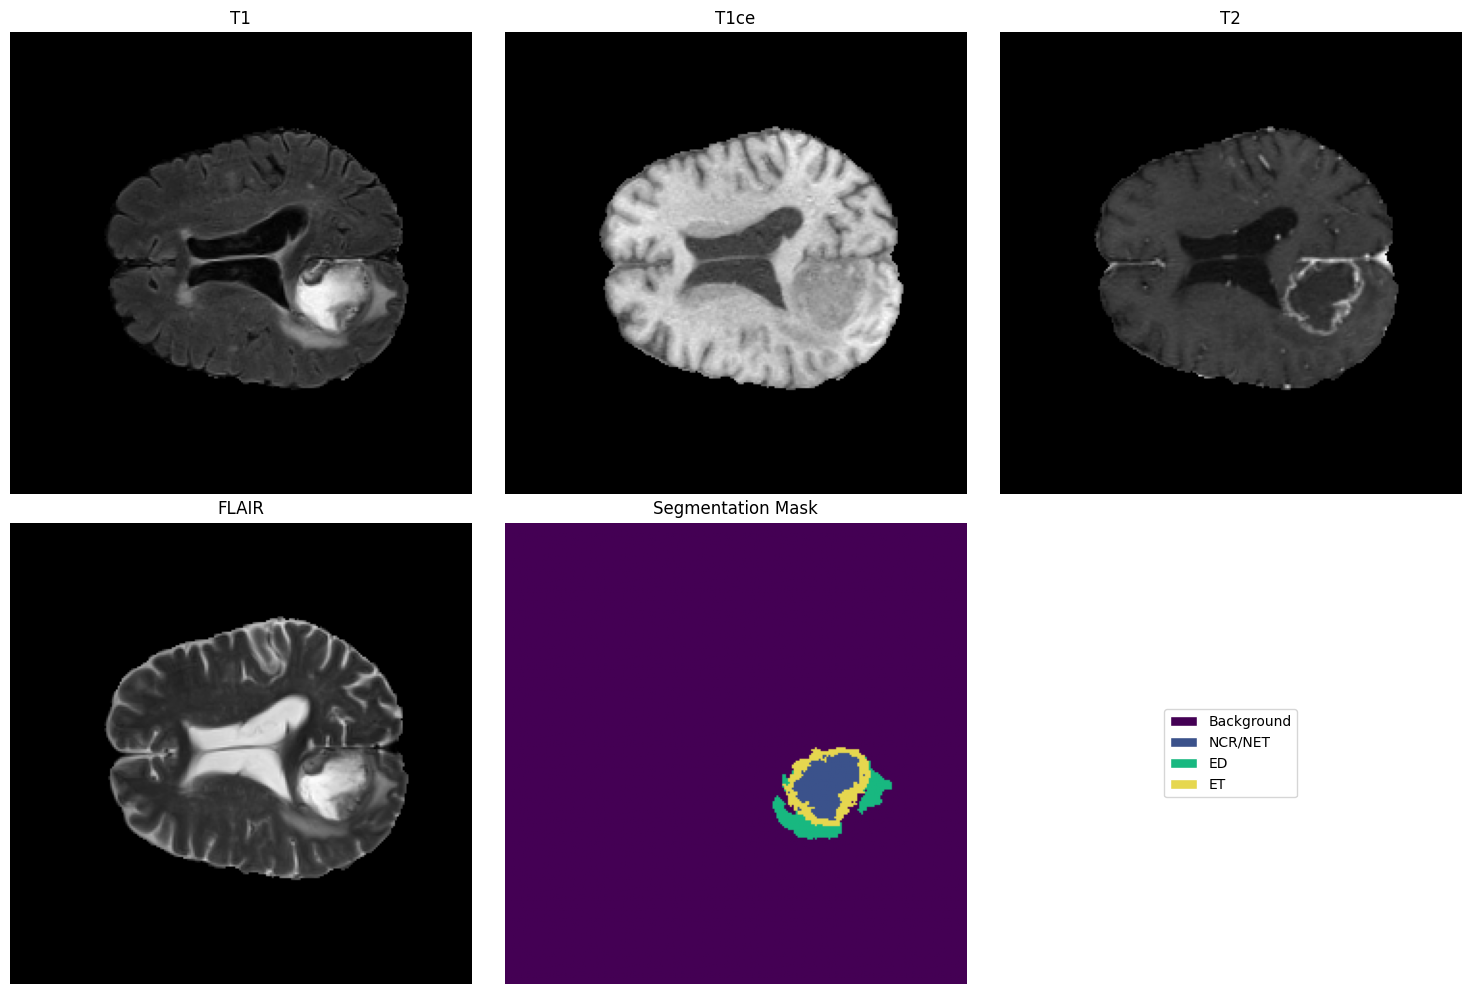

In [7]:
def visualize_sample_slice(file_path):
    """Visualize all modalities and segmentation for a single slice"""
    # Load data
    image_data, mask_data = load_h5_slice(file_path)
    
    # Get modality and tumor region names
    modality_names = get_modality_names()
    tumor_region_names = get_tumor_region_names()
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot modalities
    for i in range(4):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        # Display the modality
        ax.imshow(image_data[:, :, i], cmap='gray')
        ax.set_title(modality_names[i])
        ax.axis('off')
    
    # Create combined segmentation mask
    segmentation = np.zeros(mask_data.shape[:2])
    # Combine the tumor regions with different values
    for i in range(mask_data.shape[2]):
        segmentation[mask_data[:, :, i] > 0] = i + 1
    
    # Plot combined segmentation
    cmap = create_colormap_for_segments()
    norm = mcolors.BoundaryNorm(np.arange(0, 5) - 0.5, cmap.N)
    
    seg_ax = axes[1, 1]
    seg_ax.imshow(segmentation, cmap=cmap, norm=norm)
    seg_ax.set_title('Segmentation Mask')
    seg_ax.axis('off')
    
    # Create legend patches
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#440054', edgecolor='w', label='Background'),
        Patch(facecolor='#3b528b', edgecolor='w', label='NCR/NET'),
        Patch(facecolor='#18b880', edgecolor='w', label='ED'),
        Patch(facecolor='#e6d74f', edgecolor='w', label='ET')
    ]
    
    # Add legend to the figure
    axes[1, 2].axis('off')
    axes[1, 2].legend(handles=legend_elements, loc='center')
    
    plt.tight_layout()
    plt.show()
    
    return image_data, mask_data

# Select a sample file
sample_file = None
if h5_files:
    # Pick a file with interesting segmentation (not empty)
    for test_file in h5_files[:20]:  # Check first 20 files
        file_path = os.path.join(H5_DATA_DIR, test_file)
        try:
            _, mask_data = load_h5_slice(file_path)
            if np.any(mask_data > 0):
                sample_file = file_path
                break
        except:
            continue
    
    if sample_file:
        print(f"Visualizing sample file: {os.path.basename(sample_file)}")
        image_data, mask_data = visualize_sample_slice(sample_file)
    else:
        print("Could not find a file with segmentation. Using the first file.")
        sample_file = os.path.join(H5_DATA_DIR, h5_files[0])
        image_data, mask_data = visualize_sample_slice(sample_file)
else:
    print("No H5 files available for visualization.")

## 7. Visualize Multiple Views (Transverse, Frontal, Sagittal)

Note: The H5 dataset contains 2D slices from the 3D volume, so we need to collect slices from the same patient to reconstruct different views.

Selected patient: 41
Found 155 slices for patient 41
Reconstructing volume for T1...
Displaying T1 volume views
Volume shape: (240, 240, 155)


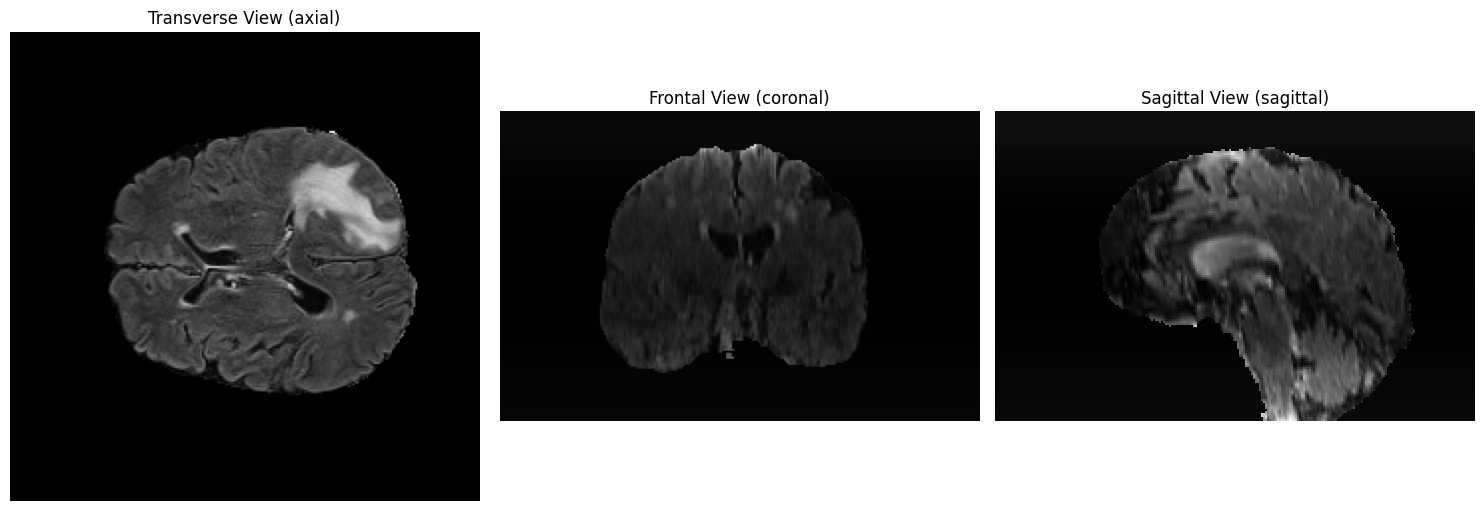

Reconstructing volume for T1ce...
Displaying T1ce volume views
Volume shape: (240, 240, 155)


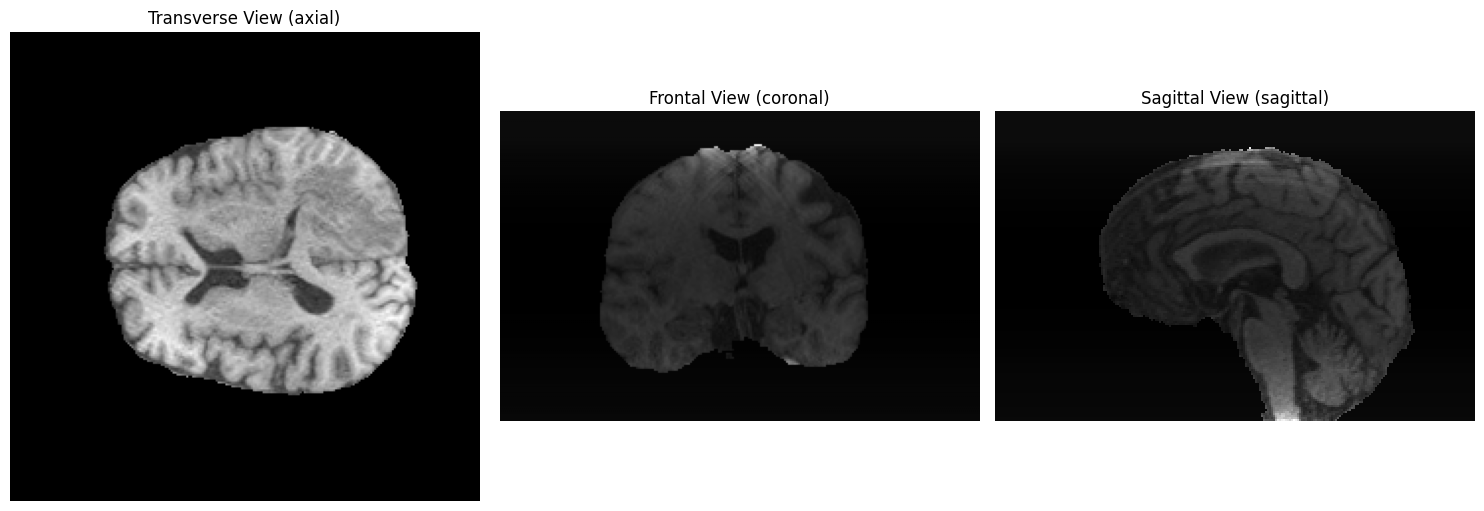

Reconstructing volume for T2...
Displaying T2 volume views
Volume shape: (240, 240, 155)


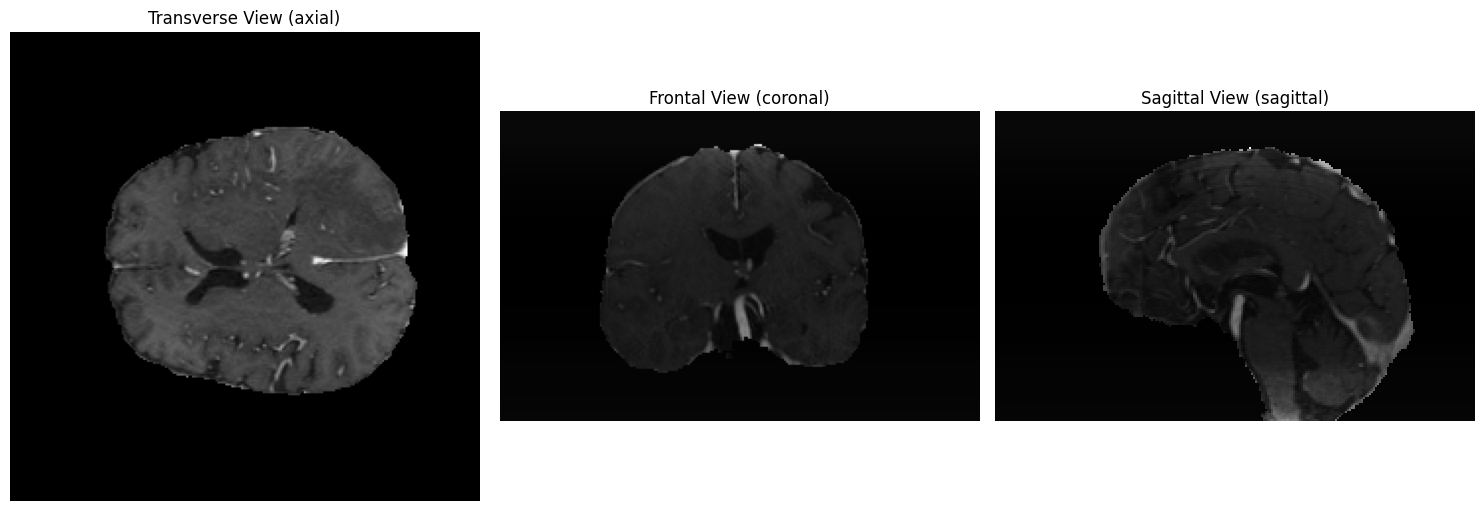

Reconstructing volume for FLAIR...
Displaying FLAIR volume views
Volume shape: (240, 240, 155)


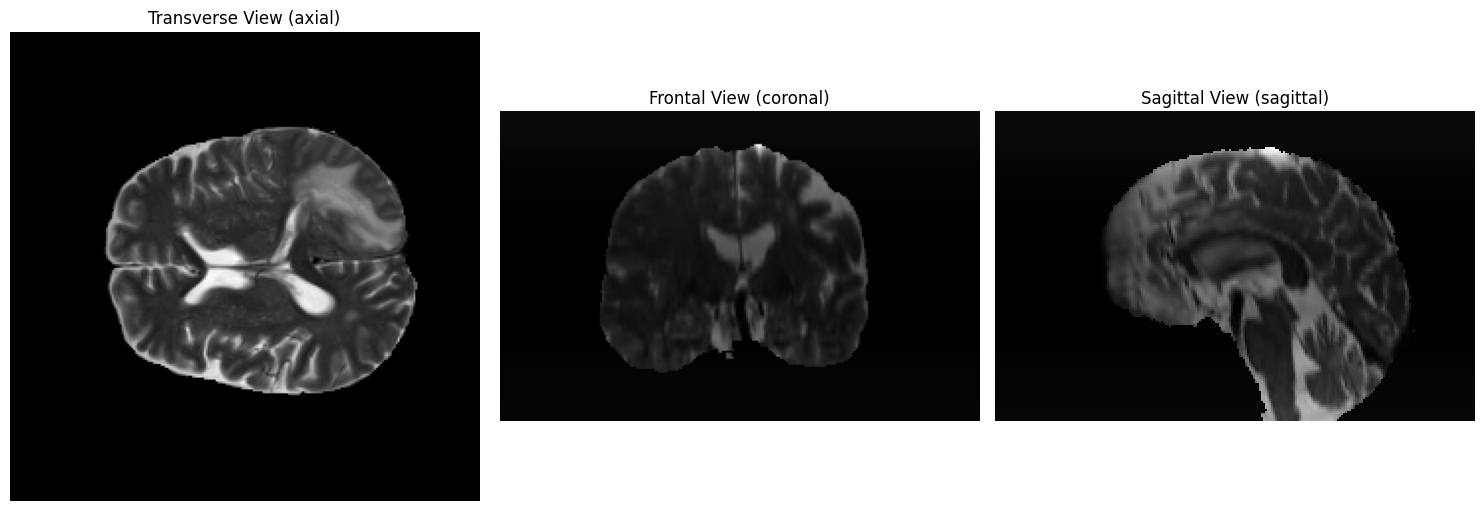

In [8]:
def get_patient_slices(metadata_df, patient_id, num_slices=155):
    """Get all slices for a specific patient"""
    if 'patient_id' not in metadata_df.columns:
        print("Error: 'patient_id' column not in metadata")
        return []
        
    # Filter for the specific patient
    patient_slices = metadata_df[metadata_df['patient_id'] == patient_id]
    
    # Get paths sorted by slice index
    if 'slice' in patient_slices.columns:
        patient_slices = patient_slices.sort_values('slice')
    
    # Get all valid file paths
    slice_paths = []
    for _, row in patient_slices.iterrows():
        if 'slice_path' in row:
            # Extract just the filename from the path in metadata
            base_filename = os.path.basename(row['slice_path'])
            h5_path = os.path.join(H5_DATA_DIR, base_filename)
            
            if os.path.exists(h5_path):
                slice_paths.append(h5_path)
                
    print(f"Found {len(slice_paths)} slices for patient {patient_id}")
    return slice_paths

def reconstruct_3d_volume(slice_paths, modality_index=1):  # Default to T1ce (index 1)
    """Reconstruct a 3D volume from 2D slices for a specific modality"""
    if not slice_paths:
        print("No slice paths provided")
        return None
        
    # Load first slice to get dimensions
    img, _ = load_h5_slice(slice_paths[0])
    height, width = img.shape[:2]
    
    # Initialize 3D volume
    volume = np.zeros((height, width, len(slice_paths)))
    
    # Fill volume with slices
    for i, path in enumerate(slice_paths):
        try:
            img, _ = load_h5_slice(path)
            volume[:, :, i] = img[:, :, modality_index]
        except Exception as e:
            print(f"Error loading {path}: {e}")
            
    return volume

def show_3d_views(volume):
    """Show transverse, frontal, and sagittal views of a 3D volume"""
    if volume is None:
        print("No volume to display")
        return
        
    middle_transverse = volume.shape[2] // 2
    middle_frontal = volume.shape[0] // 2
    middle_sagittal = volume.shape[1] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Transverse view (axial)
    axes[0].imshow(volume[:, :, middle_transverse], cmap='gray')
    axes[0].set_title('Transverse View (axial)')
    axes[0].axis('off')
    
    # Frontal view (coronal)
    axes[1].imshow(rotate(volume[:, middle_frontal, :], 90, resize=True), cmap='gray')
    axes[1].set_title('Frontal View (coronal)')
    axes[1].axis('off')
    
    # Sagittal view
    axes[2].imshow(rotate(volume[middle_sagittal, :, :], 90, resize=True), cmap='gray')
    axes[2].set_title('Sagittal View (sagittal)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Try to reconstruct a volume for a patient
if 'metadata_df' in locals() and 'patient_id' in metadata_df.columns:
    # Get unique patients
    unique_patients = metadata_df['patient_id'].unique()
    
    if len(unique_patients) > 0:
        # Select a patient
        patient_id = unique_patients[0]
        print(f"Selected patient: {patient_id}")
        
        # Get patient slices
        patient_slices = get_patient_slices(metadata_df, patient_id)
        
        if patient_slices:
            # Reconstruct volumes for all modalities
            modality_names = get_modality_names()
            
            for i, modality in enumerate(modality_names):
                print(f"Reconstructing volume for {modality}...")
                volume = reconstruct_3d_volume(patient_slices, modality_index=i)
                
                if volume is not None:
                    print(f"Displaying {modality} volume views")
                    print(f"Volume shape: {volume.shape}")
                    show_3d_views(volume)
        else:
            print("No slices found for the selected patient")
else:
    print("Metadata not loaded correctly, cannot reconstruct 3D volumes")

## 8. Visualize Segmentation Masks

/tmp/ipykernel_322666/3194990707.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


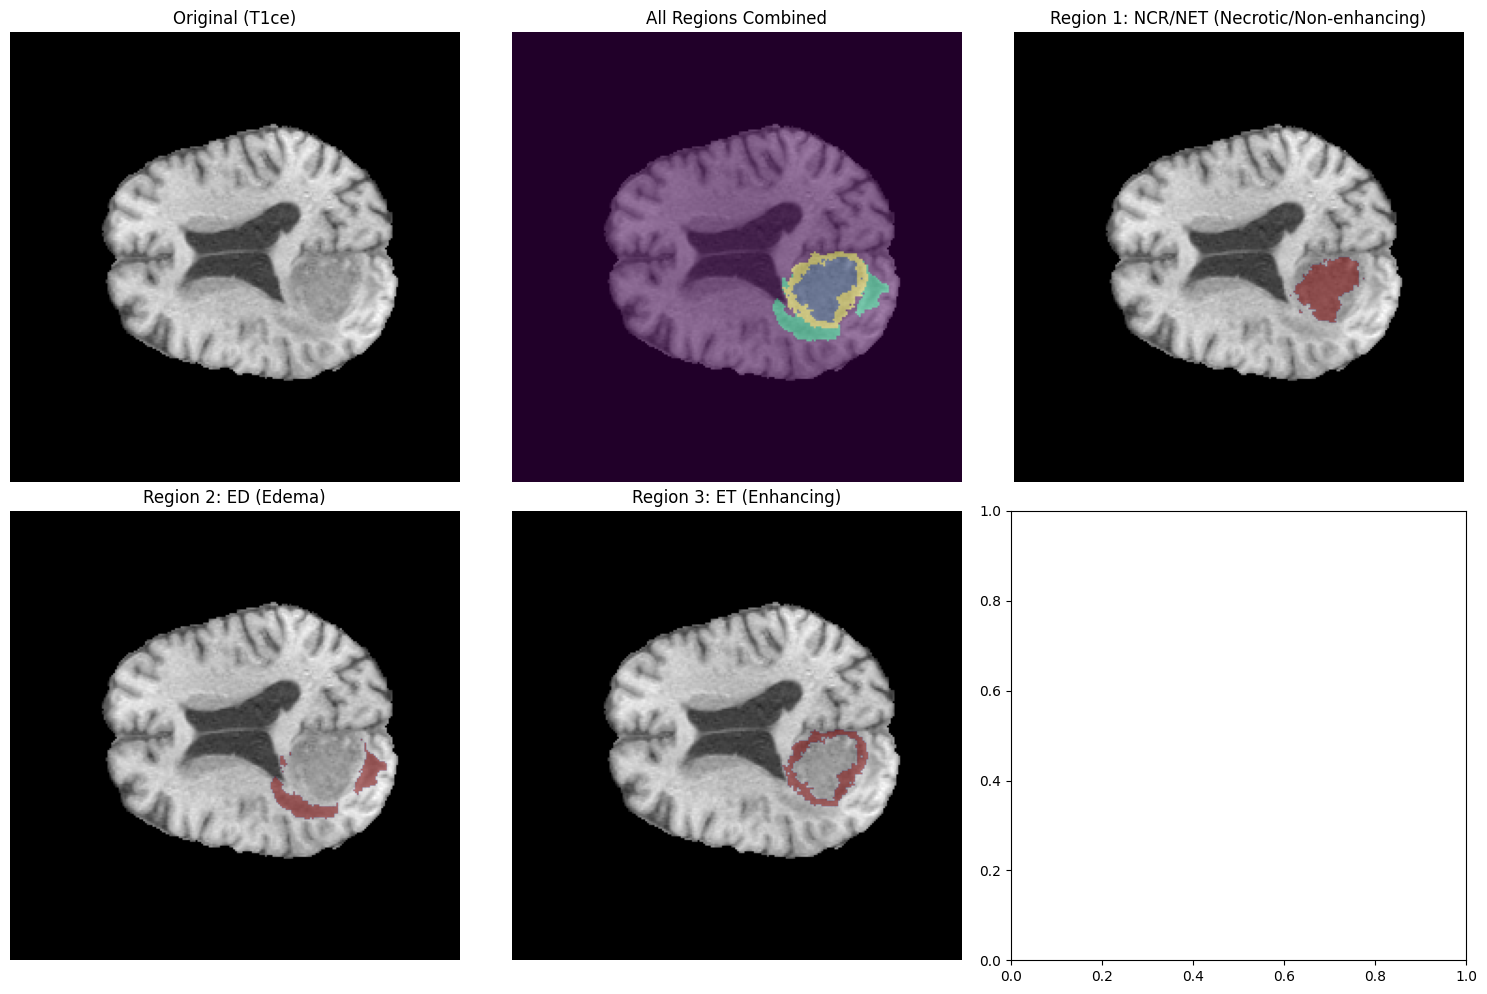

In [9]:
def visualize_segmentation_masks(file_path):
    """Visualize all segmentation masks individually"""
    # Load data
    image_data, mask_data = load_h5_slice(file_path)
    tumor_region_names = get_tumor_region_names()
    
    # Select a modality for background (T1ce or FLAIR are usually good)
    background_modality = 1  # T1ce
    
    # Create colormap
    cmap = plt.cm.get_cmap('viridis')
    
    # Create a figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Original modality
    axes[0].imshow(image_data[:, :, background_modality], cmap='gray')
    axes[0].set_title(f'Original ({get_modality_names()[background_modality]})')
    axes[0].axis('off')
    
    # Combined mask
    combined_mask = np.zeros(mask_data.shape[:2])
    # Combine the tumor regions with different values
    for i in range(mask_data.shape[2]):
        combined_mask[mask_data[:, :, i] > 0] = i + 1
    
    # Plot combined segmentation
    cmap_segments = create_colormap_for_segments()
    norm = mcolors.BoundaryNorm(np.arange(0, 5) - 0.5, cmap_segments.N)
    
    axes[1].imshow(image_data[:, :, background_modality], cmap='gray')
    axes[1].imshow(combined_mask, cmap=cmap_segments, norm=norm, alpha=0.5)
    axes[1].set_title('All Regions Combined')
    axes[1].axis('off')
    
    # Individual masks
    for i in range(mask_data.shape[2]):
        axes[i+2].imshow(image_data[:, :, background_modality], cmap='gray')
        # Show mask as overlay
        mask = mask_data[:, :, i]
        axes[i+2].imshow(mask, cmap='jet', alpha=0.5 * (mask > 0))
        axes[i+2].set_title(f'Region {i+1}: {tumor_region_names[i]}')
        axes[i+2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize segmentation masks for a sample slice
if sample_file:
    visualize_segmentation_masks(sample_file)
else:
    print("No sample file to display")

## 9. Visualize All Slices Using Montage

Creating montage for T1...
Skipping first and last 50 slices. Showing 55 middle slices.


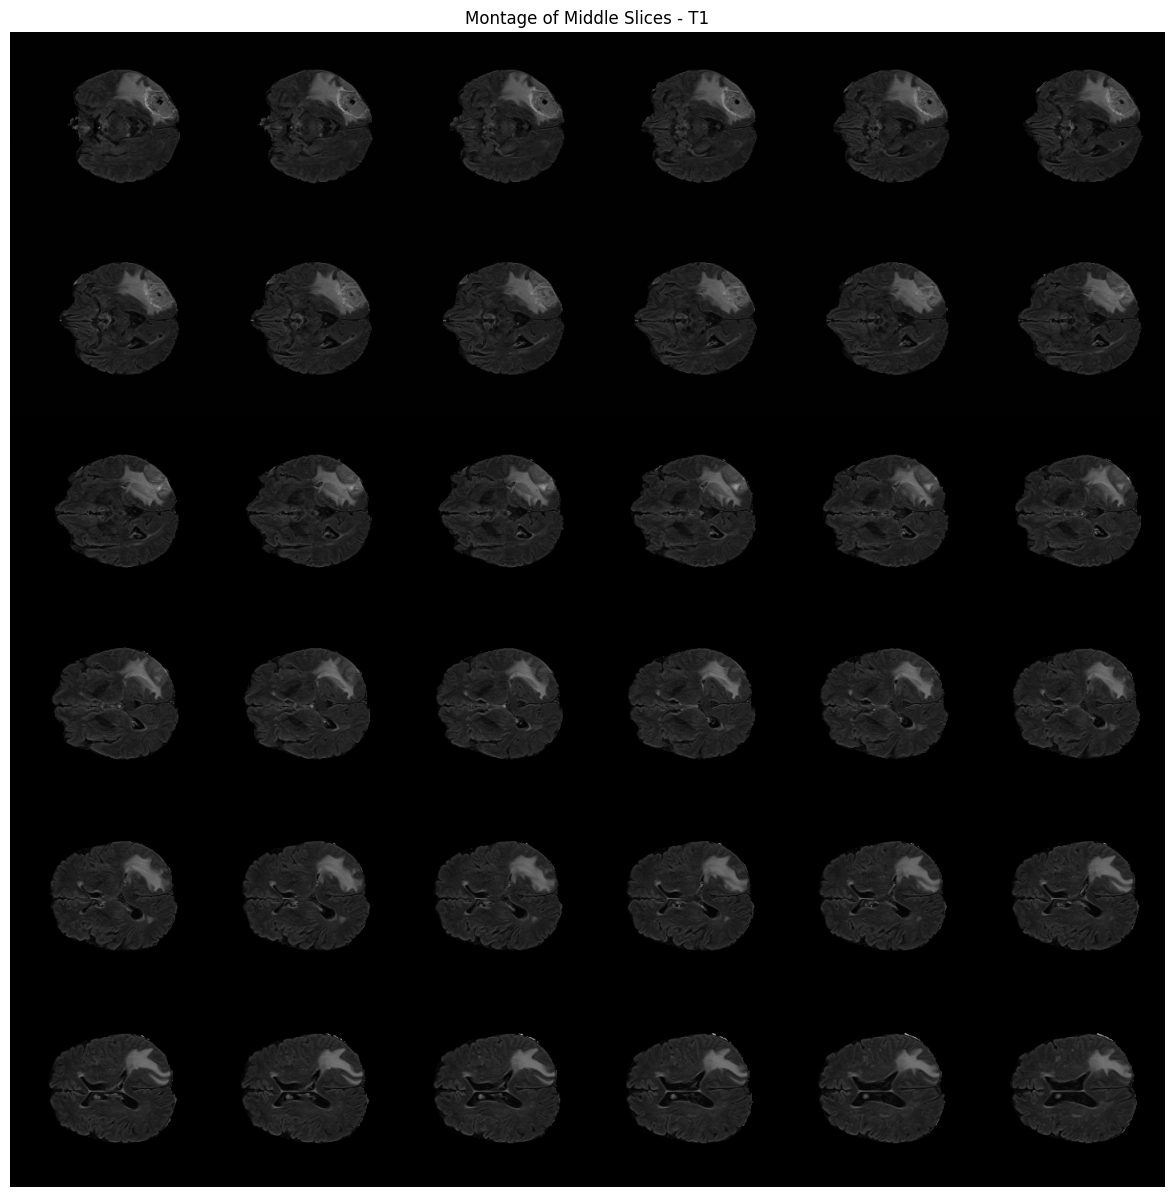

Creating montage for T1ce...
Skipping first and last 50 slices. Showing 55 middle slices.


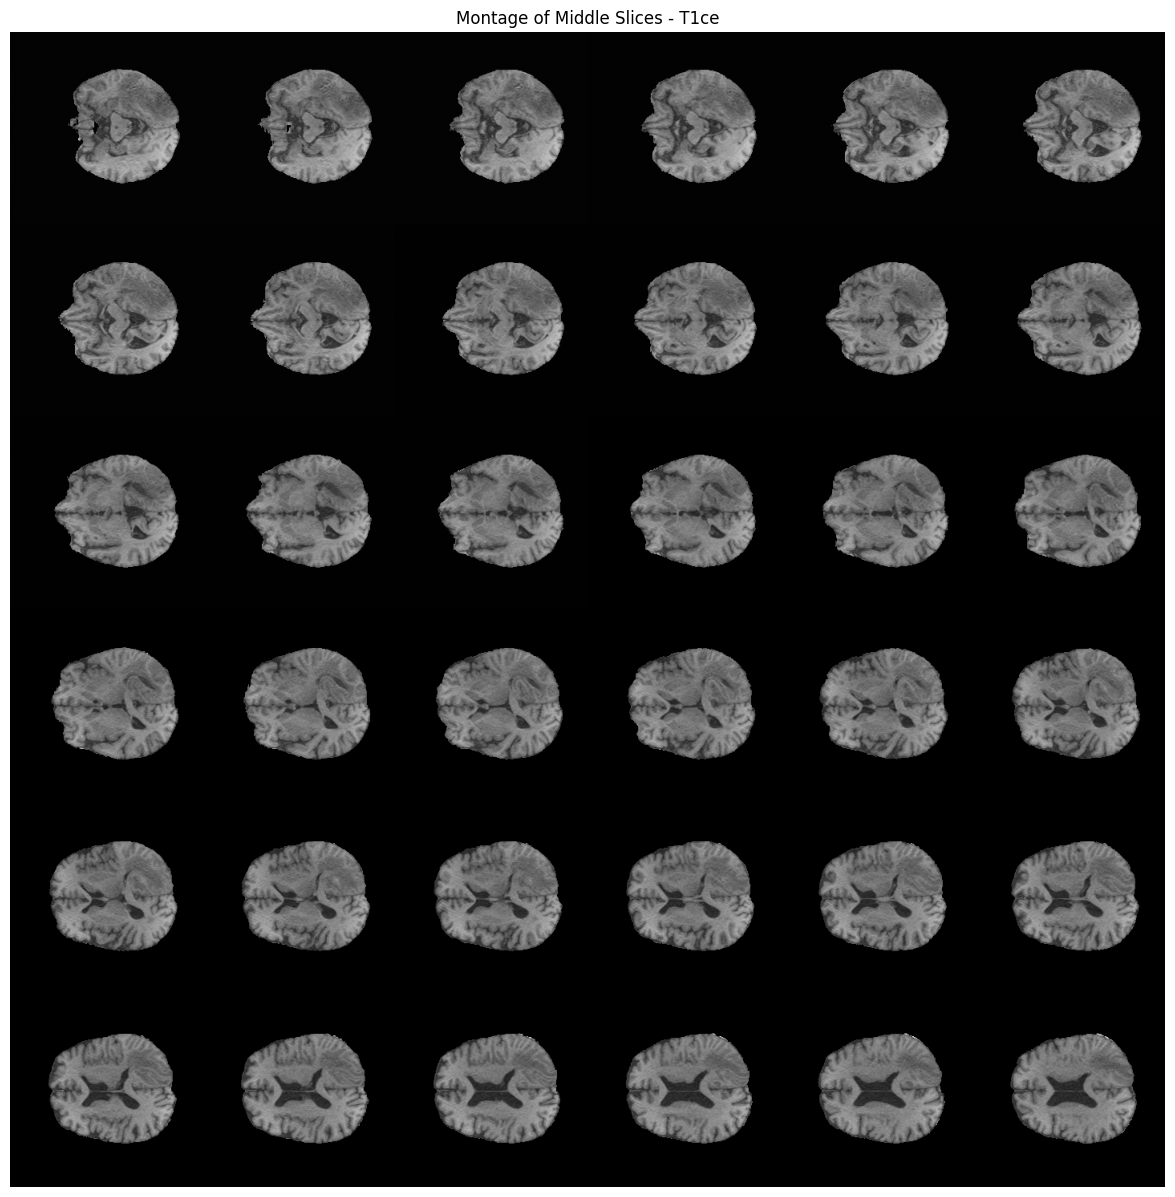

Creating montage for T2...
Skipping first and last 50 slices. Showing 55 middle slices.


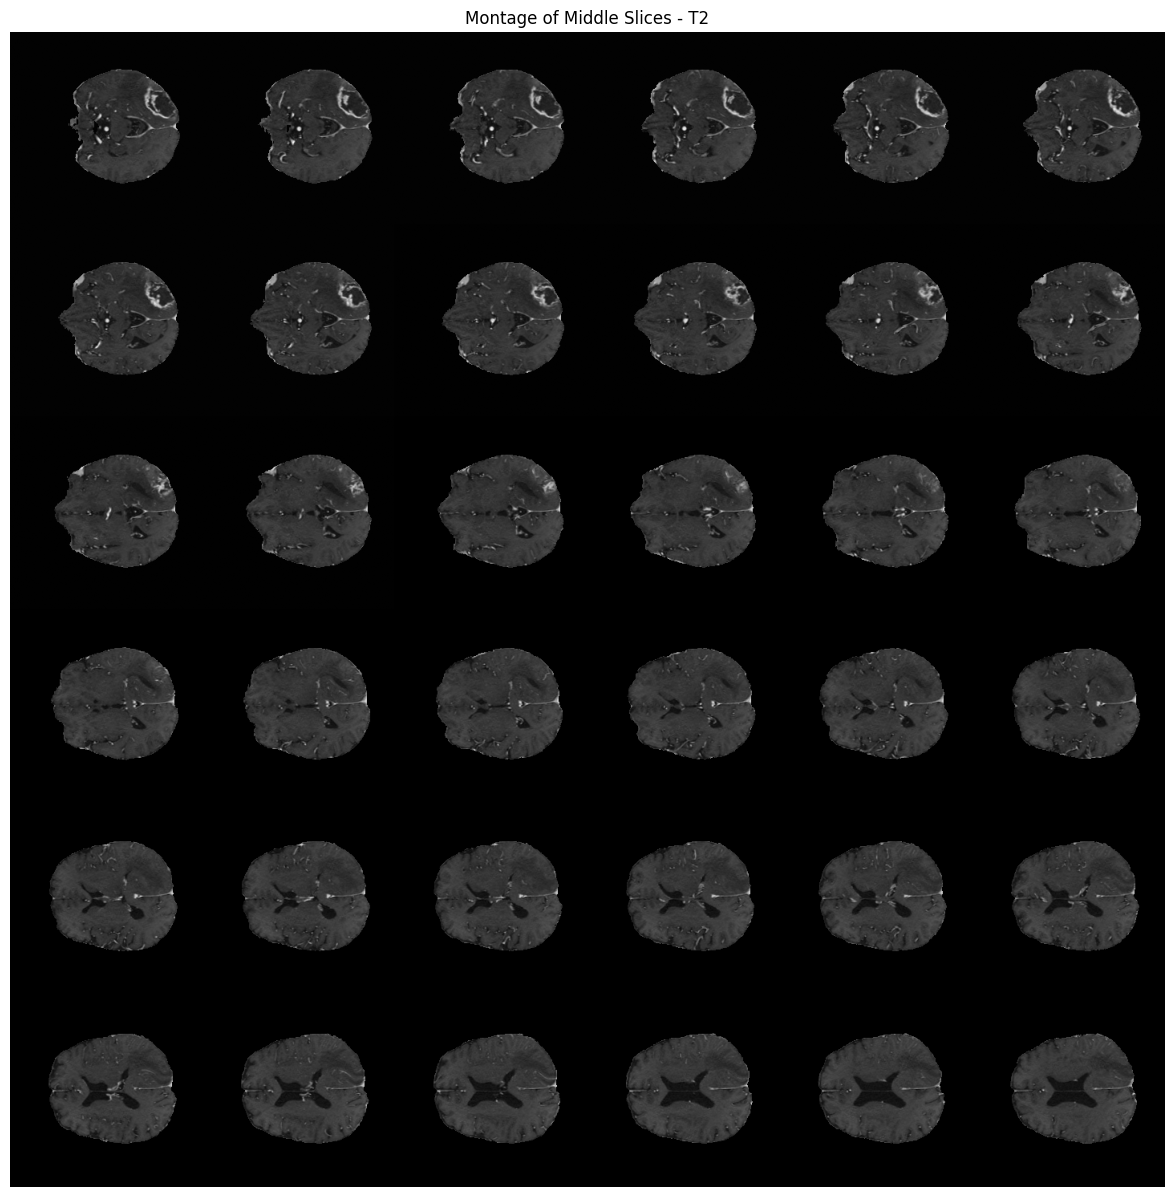

Creating montage for FLAIR...
Skipping first and last 50 slices. Showing 55 middle slices.


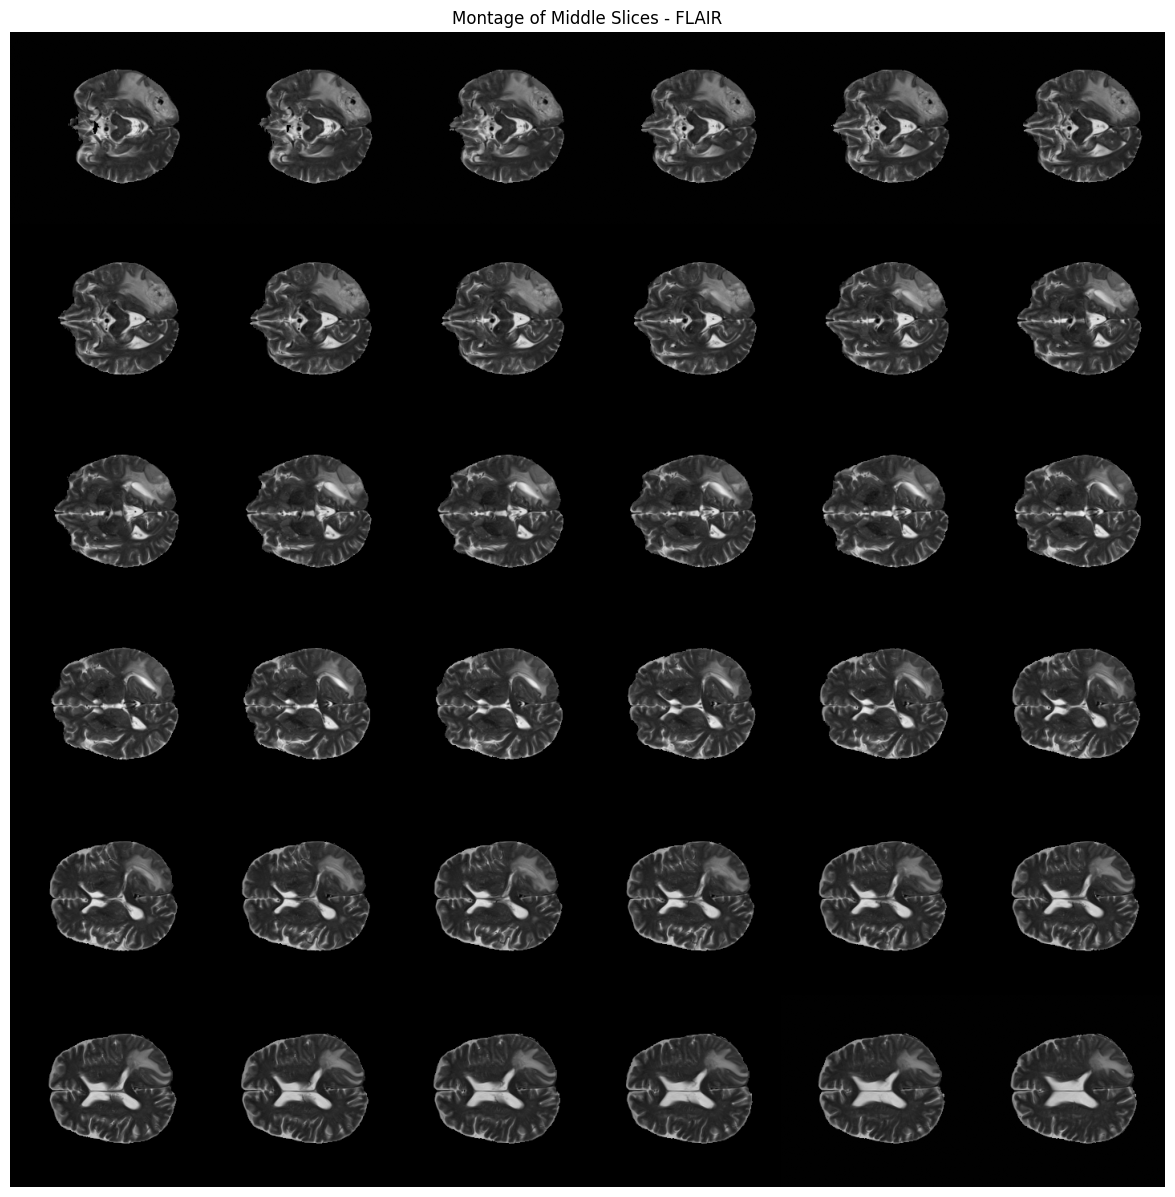

In [10]:
def create_montage_of_slices(patient_slices, modality_index=1, skip_ends=True):
    """Create a montage of slices for a given patient and modality
    
    Args:
        patient_slices: List of paths to patient slice files
        modality_index: Index of the modality to visualize (0:T1, 1:T1ce, 2:T2, 3:FLAIR)
        skip_ends: If True, skip the first and last 50 slices which often contain little information
    """
    if not patient_slices:
        print("No slices to display")
        return
    
    # Skip ends if requested and if there are enough slices
    if skip_ends and len(patient_slices) > 100:
        print(f"Skipping first and last 50 slices. Showing {len(patient_slices) - 100} middle slices.")
        patient_slices = patient_slices[50:-50]
    
    # Load selected slices for the modality
    slices = []
    for path in patient_slices:
        try:
            img, _ = load_h5_slice(path)
            slices.append(img[:, :, modality_index])
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    if not slices:
        print("Failed to load any slices")
        return
    
    # Downsample if there are too many slices (optional)
    max_slices = 36  # Adjust based on how many you want to see
    if len(slices) > max_slices:
        step = len(slices) // max_slices
        slices = slices[::step][:max_slices]  # Take every nth slice up to max_slices
        
    # Create montage
    montage_arr = montage(np.array(slices))
    
    # Plot
    plt.figure(figsize=(15, 15))
    plt.imshow(montage_arr, cmap='gray')
    plt.title(f'Montage of Middle Slices - {get_modality_names()[modality_index]}')
    plt.axis('off')
    plt.show()

# Create montage for a patient
if 'patient_slices' in locals() and patient_slices:
    # Show montage for all modalities
    for i, modality in enumerate(get_modality_names()):
        print(f"Creating montage for {modality}...")
        create_montage_of_slices(patient_slices, modality_index=i, skip_ends=True)
else:
    print("No patient slices available")

## 10. Analyze Distribution of Tumor Regions


Tumor Region Distribution:
                       Tumor Region  Pixel Count  Percentage (%)
0  NCR/NET (Necrotic/Non-enhancing)        19169        0.214707
1                        ED (Edema)        67089        0.751445
2                    ET (Enhancing)        15158        0.169780


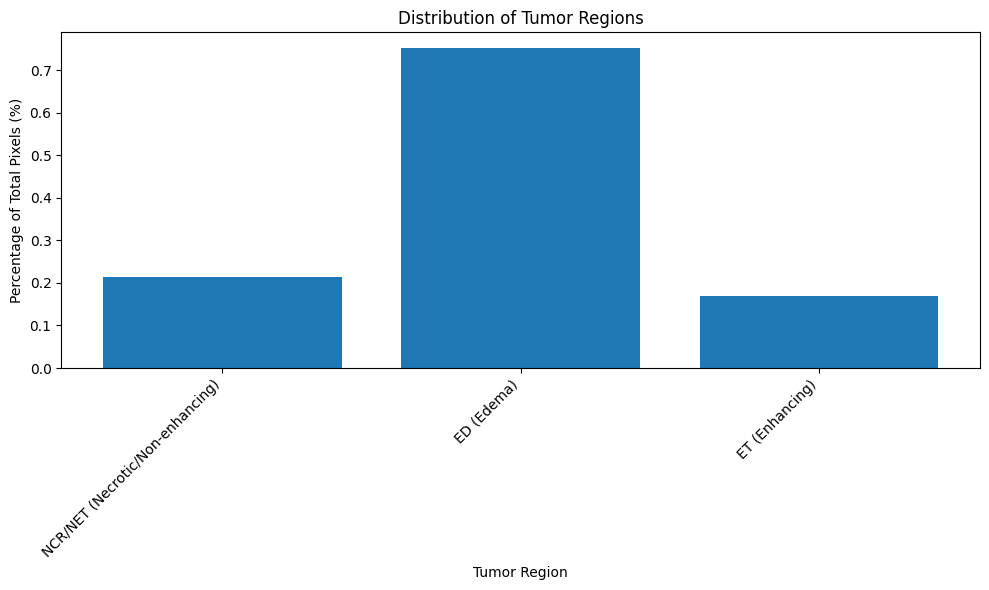

In [11]:
def analyze_tumor_distribution(patient_slices):
    """Analyze the distribution of tumor regions across slices"""
    if not patient_slices:
        print("No slices to analyze")
        return
    
    # Initialize counters
    total_pixels = 0
    tumor_region_pixels = [0, 0, 0]  # One for each tumor region
    
    # Count pixels in each region
    for path in patient_slices:
        try:
            _, mask = load_h5_slice(path)
            total_pixels += mask.shape[0] * mask.shape[1]
            
            for i in range(mask.shape[2]):
                tumor_region_pixels[i] += np.sum(mask[:, :, i] > 0)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    # Calculate percentages
    tumor_region_names = get_tumor_region_names()
    percentages = [(pixels / total_pixels) * 100 for pixels in tumor_region_pixels]
    
    # Create a dataframe for display
    data = {
        'Tumor Region': tumor_region_names,
        'Pixel Count': tumor_region_pixels,
        'Percentage (%)': percentages
    }
    distribution_df = pd.DataFrame(data)
    
    # Display results
    print("\nTumor Region Distribution:")
    print(distribution_df)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.bar(tumor_region_names, percentages)
    plt.xlabel('Tumor Region')
    plt.ylabel('Percentage of Total Pixels (%)')
    plt.title('Distribution of Tumor Regions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return distribution_df

# Analyze tumor distribution
if 'patient_slices' in locals() and patient_slices:
    distribution_df = analyze_tumor_distribution(patient_slices)
else:
    print("No patient slices available for analysis")

## 11. Visualize Modalities for Different Patients

## 11. Visualize Modalities for Different Patients


Patient: 41
Found 155 slices for patient 41


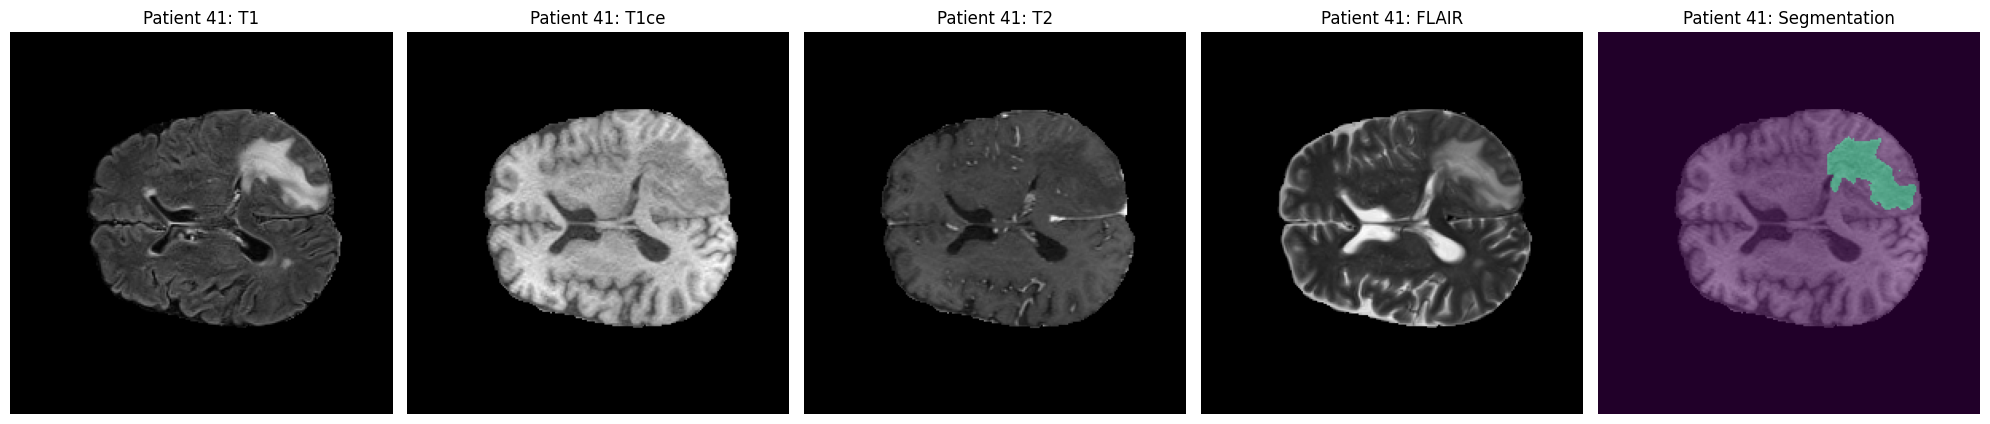


Patient: 185
Found 155 slices for patient 185


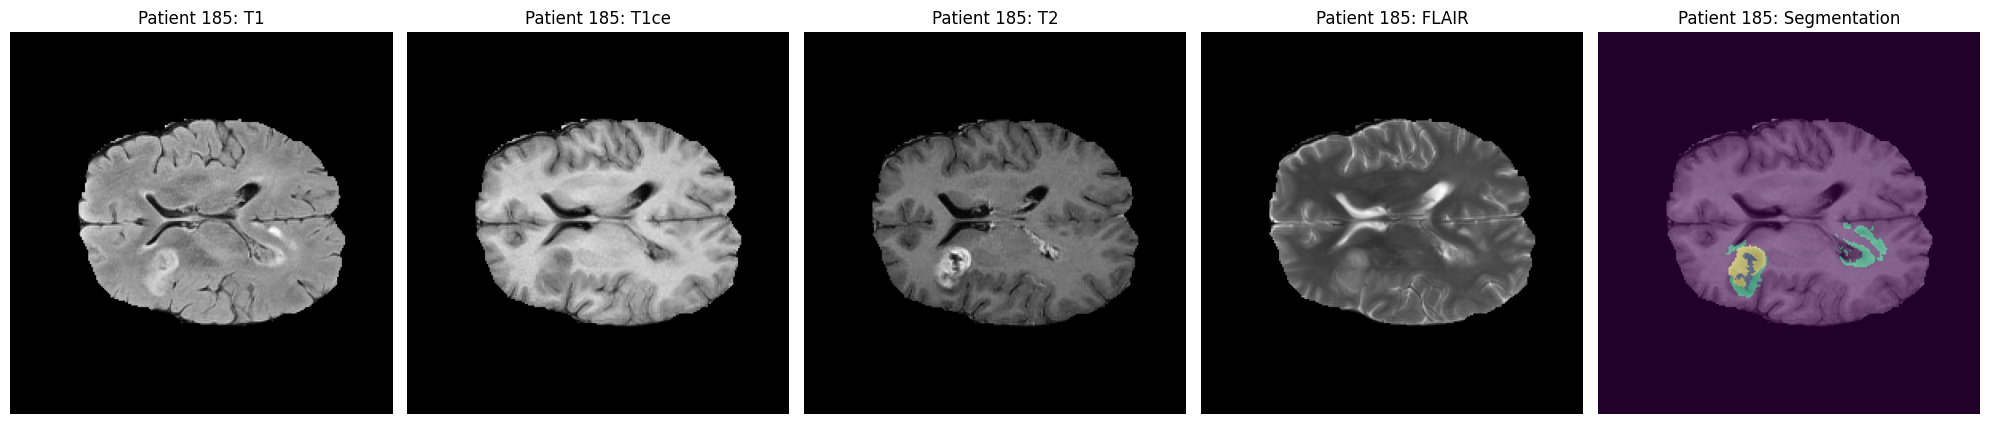


Patient: 135
Found 155 slices for patient 135


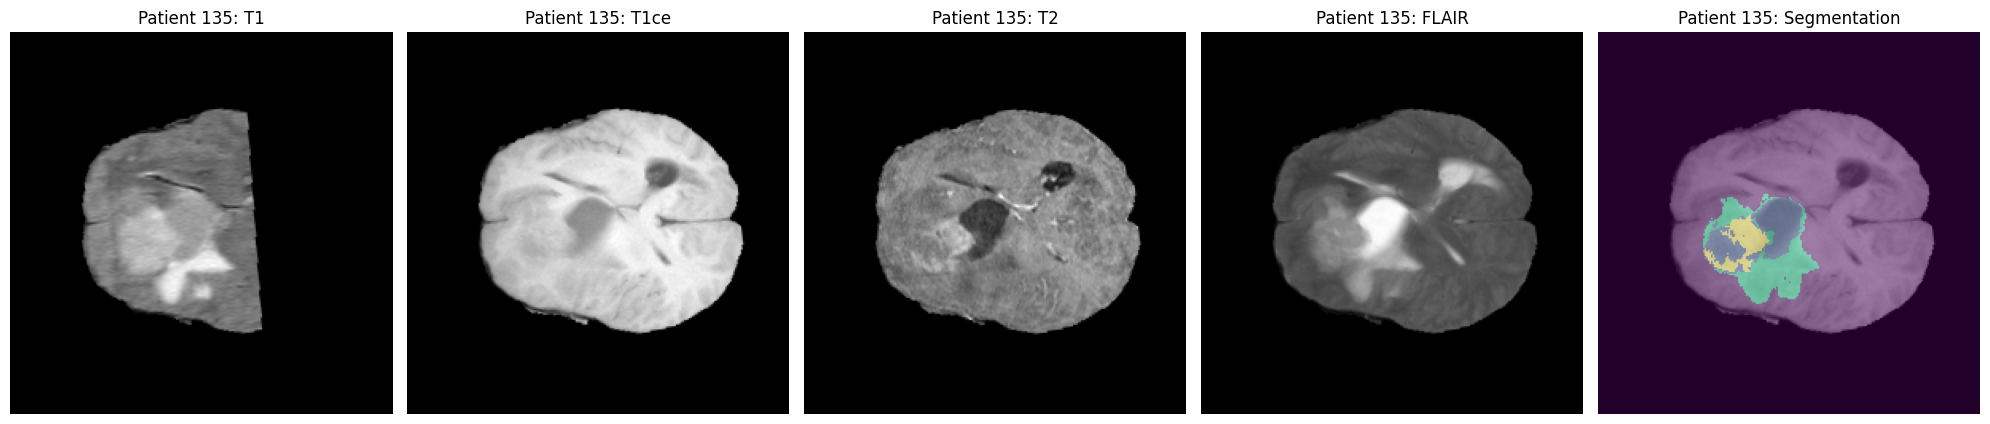

In [12]:
def visualize_modalities_for_different_patients(metadata_df, num_patients=3):
    """Visualize modalities for different patients"""
    if 'patient_id' not in metadata_df.columns:
        print("Error: 'patient_id' column not in metadata")
        return
        
    # Get unique patients
    unique_patients = metadata_df['patient_id'].unique()
    
    if len(unique_patients) < num_patients:
        num_patients = len(unique_patients)
        print(f"Only {num_patients} patients available")
    
    # Select patients
    selected_patients = unique_patients[:num_patients]
    
    for patient_id in selected_patients:
        print(f"\nPatient: {patient_id}")
        
        # Get patient slices
        patient_slices = get_patient_slices(metadata_df, patient_id)
        
        if not patient_slices:
            print(f"No slices found for patient {patient_id}")
            continue
            
        # Find a slice with tumor if possible
        middle_slice_idx = len(patient_slices) // 2
        middle_slice_path = patient_slices[middle_slice_idx]
        
        # Try to find a slice with tumor
        for path in patient_slices[middle_slice_idx:]:
            try:
                _, mask = load_h5_slice(path)
                if np.any(mask > 0):
                    middle_slice_path = path
                    break
            except:
                continue
        
        try:
            image_data, mask_data = load_h5_slice(middle_slice_path)
            
            # Plot modalities
            fig, axes = plt.subplots(1, 5, figsize=(20, 5))
            
            # Show each modality
            modality_names = get_modality_names()
            for i, modality in enumerate(modality_names):
                axes[i].imshow(image_data[:, :, i], cmap='gray')
                axes[i].set_title(f'Patient {patient_id}: {modality}')
                axes[i].axis('off')
            
            # Show segmentation
            # Create combined segmentation mask
            segmentation = np.zeros(mask_data.shape[:2])
            for i in range(mask_data.shape[2]):
                segmentation[mask_data[:, :, i] > 0] = i + 1
            
            # Apply colormap
            cmap = create_colormap_for_segments()
            norm = mcolors.BoundaryNorm(np.arange(0, 5) - 0.5, cmap.N)
            
            axes[4].imshow(image_data[:, :, 1], cmap='gray')  # T1ce as background
            axes[4].imshow(segmentation, cmap=cmap, norm=norm, alpha=0.5)
            axes[4].set_title(f'Patient {patient_id}: Segmentation')
            axes[4].axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing {middle_slice_path}: {e}")
            import traceback
            traceback.print_exc()

# Visualize modalities for different patients
if 'metadata_df' in locals() and 'patient_id' in metadata_df.columns:
    visualize_modalities_for_different_patients(metadata_df, num_patients=3)
else:
    print("Metadata not loaded correctly")

## 12. Class Distribution Analysis


Class Distribution (from sample of 30 slices):
                             Region  Pixel Count  Percentage (%)
0                        Background      1718683       99.460822
1  NCR/NET (Necrotic/Non-enhancing)         3249        0.188021
2                        ED (Edema)         4448        0.257407
3                    ET (Enhancing)         1620        0.093750


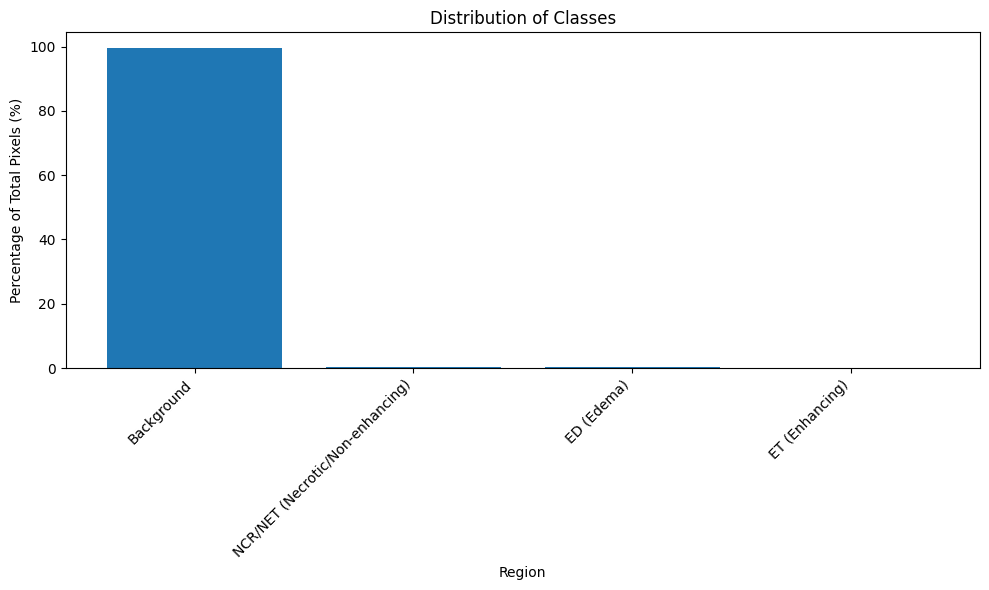

In [13]:
def analyze_class_distribution(metadata_df, h5_data_dir, sample_size=50):
    """Analyze distribution of tumor classes across the dataset"""
    if not os.path.exists(h5_data_dir) or not os.listdir(h5_data_dir):
        print(f"Error: H5 data directory not found or empty at {h5_data_dir}")
        return
    
    # Randomly sample some files
    h5_files = [f for f in os.listdir(h5_data_dir) if f.endswith('.h5')]
    
    if len(h5_files) == 0:
        print("No H5 files found in the directory.")
        return
        
    if len(h5_files) > sample_size:
        import random
        sample_files = random.sample(h5_files, sample_size)
    else:
        sample_files = h5_files
    
    # Initialize counters
    total_pixels = 0
    background_pixels = 0
    tumor_region_pixels = [0, 0, 0]  # One for each tumor region
    
    # Count pixels in each class
    for file_name in sample_files:
        try:
            file_path = os.path.join(h5_data_dir, file_name)
            _, mask = load_h5_slice(file_path)
            
            # Count total pixels
            slice_total = mask.shape[0] * mask.shape[1]
            total_pixels += slice_total
            
            # Count background (no tumor) pixels
            all_tumor = np.zeros(mask.shape[:2], dtype=bool)
            for i in range(mask.shape[2]):
                tumor_pixels = mask[:, :, i] > 0
                all_tumor |= tumor_pixels
                tumor_region_pixels[i] += np.sum(tumor_pixels)
            
            background_pixels += slice_total - np.sum(all_tumor)
            
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    
    # Calculate percentages
    region_names = ['Background'] + get_tumor_region_names()
    pixel_counts = [background_pixels] + tumor_region_pixels
    percentages = [(count / total_pixels) * 100 for count in pixel_counts]
    
    # Create a dataframe for display
    data = {
        'Region': region_names,
        'Pixel Count': pixel_counts,
        'Percentage (%)': percentages
    }
    distribution_df = pd.DataFrame(data)
    
    # Display results
    print("\nClass Distribution (from sample of", sample_size, "slices):")
    print(distribution_df)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.bar(region_names, percentages)
    plt.xlabel('Region')
    plt.ylabel('Percentage of Total Pixels (%)')
    plt.title('Distribution of Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return distribution_df

# Analyze class distribution
if os.path.exists(H5_DATA_DIR):
    distribution_df = analyze_class_distribution(metadata_df, H5_DATA_DIR, sample_size=30)
else:
    print(f"H5 data directory not found at {H5_DATA_DIR}")

## 13. Summary of Dataset Properties

In [14]:
def summarize_dataset(metadata_df, h5_data_dir):
    """Provide a summary of the dataset properties"""
    print("\n" + "="*50)
    print("BraTS 2020 H5 Dataset Summary")
    print("="*50)
    
    # Metadata summary
    if 'metadata_df' in locals() and not metadata_df.empty:
        print("\n--- Metadata Summary ---")
        print(f"Total entries: {len(metadata_df)}")
        
        if 'patient_id' in metadata_df.columns:
            print(f"Unique patients: {metadata_df['patient_id'].nunique()}")
        
        if 'slice_index' in metadata_df.columns:
            print(f"Slice index range: {metadata_df['slice_index'].min()} - {metadata_df['slice_index'].max()}")
    
    # File summary
    print("\n--- File Summary ---")
    if os.path.exists(h5_data_dir):
        h5_files = [f for f in os.listdir(h5_data_dir) if f.endswith('.h5')]
        print(f"Total H5 files: {len(h5_files)}")
        
        # Check one file for dimensions
        if h5_files:
            example_file = os.path.join(h5_data_dir, h5_files[0])
            try:
                with h5py.File(example_file, 'r') as hf:
                    if 'image' in hf:
                        print(f"Image dimensions: {hf['image'].shape}")
                    if 'mask' in hf:
                        print(f"Mask dimensions: {hf['mask'].shape}")
            except Exception as e:
                print(f"Error reading H5 file: {e}")
    
    # Modality and tumor region summary
    print("\n--- Content Summary ---")
    print(f"Modalities: {get_modality_names()}")
    print(f"Tumor Regions: {get_tumor_region_names()}")
    
    print("\n" + "="*50)

# Summarize dataset
if os.path.exists(H5_DATA_DIR):
    summarize_dataset(metadata_df, H5_DATA_DIR)
else:
    print(f"H5 data directory not found at {H5_DATA_DIR}")


BraTS 2020 H5 Dataset Summary

--- Metadata Summary ---
Total entries: 57195
Unique patients: 369

--- File Summary ---
Total H5 files: 57195
Image dimensions: (240, 240, 4)
Mask dimensions: (240, 240, 3)

--- Content Summary ---
Modalities: ['T1', 'T1ce', 'T2', 'FLAIR']
Tumor Regions: ['NCR/NET (Necrotic/Non-enhancing)', 'ED (Edema)', 'ET (Enhancing)']

